In [1]:
!pip install torch torchvision transformers pillow matplotlib open3d accelerate
!pip install torch torchvision torchaudio
!pip install open3d
!pip install git+https://github.com/openai/shap-e.git
!pip install matplotlib Pillow
!pip install trimesh pyrender

  Cloning https://github.com/openai/shap-e.git to c:\users\snehith kumar\appdata\local\temp\pip-req-build-novjcjlp
  Resolved https://github.com/openai/shap-e.git to commit 50131012ee11c9d2617f3886c10f000d3c7a3b43
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Cloning https://github.com/openai/CLIP.git to c:\users\snehith kumar\appdata\local\temp\pip-install-s6liqa57\clip_8cc1252138474883a9c04e771cadae70
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/shap-e.git 'C:\Users\Snehith Kumar\AppData\Local\Temp\pip-req-build-novjcjlp'
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\Snehith Kumar\AppData\Local\Temp\pip-install-s6liqa57\clip_8cc1252138474883a9c04e771cadae70'


Enter input mode ('image'):  image
Enter full path to image:  C:\Users\Snehith Kumar\Downloads\car.jpg


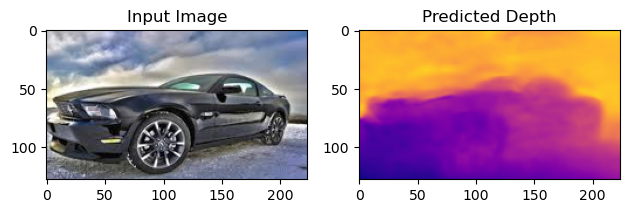

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat May 10 19:49:01 2025

@author: Snehith Kumar
"""

# -*- coding: utf-8 -*-
"""
3D Mesh Generator from Image (via Depth Estimation) or Text (Shap-E Real 3D Generation)
@author: Snehith Kumar
"""

import os
import torch
import numpy as np
from PIL import Image
import open3d as o3d
from matplotlib import pyplot as plt
from transformers import GLPNImageProcessor, GLPNForDepthEstimation

# Create output directory
os.makedirs("output", exist_ok=True)

# Choose mode
mode = input("Enter input mode ('image'): ").strip().lower()

if mode == "image":
    image_path = input("Enter full path to image: ").strip()
    if not os.path.exists(image_path):
        raise FileNotFoundError("Image path is invalid!")

    image = Image.open(image_path)

    # Resize image to multiples of 32
    new_height = 480 if image.height > 480 else image.height
    new_height -= (new_height % 32)
    new_width = int(new_height * image.width / image.height)
    diff = new_width % 32
    new_width = new_width - diff if diff < 16 else new_width + 32 - diff
    new_size = (new_width, new_height)
    image = image.resize(new_size)

    # Load depth model
    feature_extractor = GLPNImageProcessor.from_pretrained("vinvino02/glpn-nyu")
    model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

    # Predict depth
    inputs = feature_extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth

    # Post-process depth
    pad = 16
    depth = predicted_depth.squeeze().cpu().numpy() * 1000.0
    depth = depth[pad:-pad, pad:-pad]
    image = image.crop((pad, pad, image.width - pad, image.height - pad))

    # Show result
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image)
    ax[0].set_title("Input Image")
    ax[1].imshow(depth, cmap='plasma')
    ax[1].set_title("Predicted Depth")
    plt.tight_layout()
    plt.pause(2)
    plt.close()

    # Convert to RGBD
    width, height = image.size
    depth_image = (depth * 255 / np.max(depth)).astype('uint8')
    image_np = np.array(image)

    depth_o3d = o3d.geometry.Image(depth_image)
    image_o3d = o3d.geometry.Image(image_np)

    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        image_o3d, depth_o3d, convert_rgb_to_intensity=False
    )

    # Camera intrinsics
    camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
    camera_intrinsic.set_intrinsics(width, height, 500, 500, width / 2, height / 2)

    # Generate point cloud
    pcd_raw = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
    o3d.visualization.draw_geometries([pcd_raw])

    # Filter and process point cloud
    _, ind = pcd_raw.remove_statistical_outlier(nb_neighbors=20, std_ratio=6.0)
    pcd = pcd_raw.select_by_index(ind)
    pcd.estimate_normals()
    pcd.orient_normals_to_align_with_direction()

    o3d.visualization.draw_geometries([pcd])

    # Mesh via Poisson reconstruction
    mesh, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=10, n_threads=1)
    mesh.compute_vertex_normals()
    mesh.rotate(mesh.get_rotation_matrix_from_xyz((np.pi, 0, 0)), center=(0, 0, 0))

    # Save mesh
    output_path = "./output/image_mesh.obj"
    o3d.io.write_triangle_mesh(output_path, mesh)
    o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)
    print(f"✅ 3D mesh saved to '{output_path}'")

elif mode == "text":
    # Import Shap-E
    from shap_e.diffusion.sample import sample_latents
    from shap_e.diffusion.gaussian_diffusion import diffusion_from_config
    from shap_e.models.download import load_model
    from shap_e.diffusion.gaussian_diffusion import create_gaussian_diffusion

    from shap_e.util.notebooks import decode_latent_mesh

    prompt = input("Enter a description (e.g., 'a flying bird'): ").strip()
    print(f"Generating 3D mesh from text prompt: '{prompt}'")

    # Load model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model, diffusion = create_model_and_diffusion('text300M')
    model.eval().to(device)

    # Generate latent 3D
    latents = sample_latents(
        batch_size=1,
        model=model,
        diffusion=diffusion,
        guidance_scale=15.0,
        model_kwargs=dict(texts=[prompt]),
        progress=True,
        device=device,
    )

    # Decode and save mesh
    mesh = decode_latent_mesh(latents[0].cpu())
    output_path = "./output/text_based_model.obj"
    with open(output_path, 'w') as f:
        mesh.write_obj(f)

    print(f"✅ Real 3D mesh saved to '{output_path}'")

    # Visualize
    mesh_o3d = o3d.io.read_triangle_mesh(output_path)
    mesh_o3d.compute_vertex_normals()
    mesh_o3d.rotate(mesh_o3d.get_rotation_matrix_from_xyz((np.pi, 0, 0)), center=(0, 0, 0))
    o3d.visualization.draw_geometries([mesh_o3d], mesh_show_back_face=True)

else:
    raise ValueError("Mode must be either 'image' or 'text'")
